In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy import signal
from scipy import misc
from scipy import fftpack

First of all, let's try using `scipy` to implement FFT-based convolution.

In [4]:
sig = np.random.randn(1000)
autocorr = signal.fftconvolve(sig, sig[::-1], mode='full')

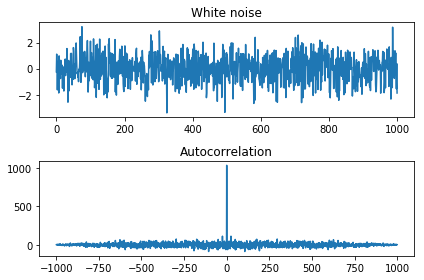

In [7]:
fig, (ax_orig, ax_mag) = plt.subplots(2, 1)
ax_orig.plot(sig)
ax_orig.set_title('White noise')
ax_mag.plot(np.arange(-len(sig)+1,len(sig)), autocorr)
ax_mag.set_title('Autocorrelation')
fig.tight_layout()

In [9]:
face = misc.face(gray=True)
kernel = np.outer(signal.gaussian(70, 8), signal.gaussian(70, 8))
blurred = signal.fftconvolve(face, kernel, mode='same')

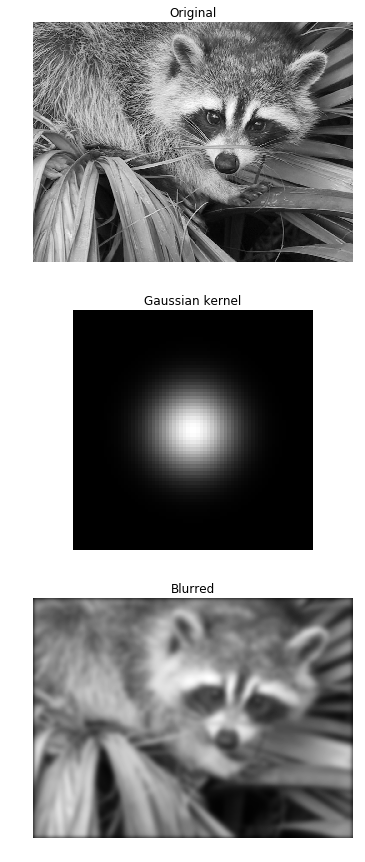

In [10]:
fig, (ax_orig, ax_kernel, ax_blurred) = plt.subplots(3, 1,
...                                                      figsize=(6, 15))
ax_orig.imshow(face, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_kernel.imshow(kernel, cmap='gray')
ax_kernel.set_title('Gaussian kernel')
ax_kernel.set_axis_off()
ax_blurred.imshow(blurred, cmap='gray')
ax_blurred.set_title('Blurred')
ax_blurred.set_axis_off()

Then, `numpy`:

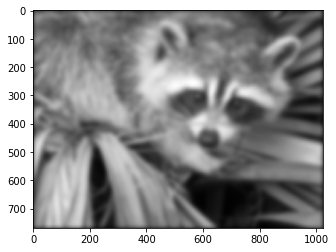

In [42]:
# Copy-and-paste some codes from SciPy's fftconvolve
# We have to pack input and filter size to a specific shape (fshape)
def _centered(arr, newshape):
    # Return the center newshape portion of the array.
    newshape = np.asarray(newshape)
    currshape = np.array(arr.shape)
    startind = (currshape - newshape) // 2
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

in1, in2 = face, kernel

s1 = np.array(in1.shape)
s2 = np.array(in2.shape)
shape = s1 + s2 - 1

fshape = [fftpack.helper.next_fast_len(int(d)) for d in shape]
fslice = tuple([slice(0, int(sz)) for sz in shape])

sp1 = np.fft.rfftn(in1, fshape)
sp2 = np.fft.rfftn(in2, fshape)
ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice].copy())
ret = _centered(ret, s1)
plt.imshow(ret, cmap='gray')

At last, let's try `tensorflow`:

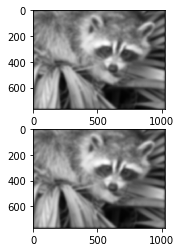

In [69]:
tf.reset_default_graph()

image = tf.placeholder(tf.float32, shape=s1)
filter_ = tf.placeholder(tf.float32, shape=s2)

fft_image = tf.spectral.rfft2d(image, fshape)
fft_filter = tf.spectral.rfft2d(filter_, fshape)
fft_result = tf.multiply(fft_image, fft_filter)
result = tf.spectral.irfft2d(fft_result, fshape)

conv_image = tf.expand_dims(image, axis=0)
conv_image = tf.expand_dims(conv_image, axis=3)
conv_filter =  tf.expand_dims(filter_, axis=2)
conv_filter =  tf.expand_dims(conv_filter, axis=2)

conv_result = tf.nn.convolution(conv_image, conv_filter, 'SAME')

fig, (ax1, ax2) = plt.subplots(2, 1)

with tf.Session() as sess:
    np_result = sess.run(result, feed_dict={image: face, filter_: kernel})
    np_result = _centered(np_result[fslice], s1)
    np_conv_result = sess.run(conv_result, feed_dict={image: face, filter_: kernel})
    
    ax1.imshow(np_result, cmap='gray')
    ax2.imshow(np_conv_result[0, :, :, 0], cmap='gray')